## **1. Dataset Preparation**

### 1.1 Libraries Used

In [1]:
import joblib
import math
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, cross_val_score, learning_curve, validation_curve
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import ExtraTreesClassifier

In [1299]:
# Verify if dataset contains valid amount of packets
csv_dir = '../dataset/s6_orig'
csv_files = os.listdir(csv_dir)

def verify_data_columns(csv_dir, files):
    for csi_file in files:
        if not csi_file.endswith('.csv'):
            continue

        csi_data = pd.read_csv(os.path.join(csv_dir, csi_file))
        if csi_data.shape[0] != 250:
            print(csi_file)

# verify_data_columns(csv_dir, csv_files)

In [2]:
# List, combine and save all the data in single csv file
# Set 1 data collection
csv_dir_s1 = '../dataset/s1_orig'
s1_files = os.listdir(csv_dir_s1)

# Set 2 data collection
csv_dir_s2 = '../dataset/s2_orig'
s2_files = os.listdir(csv_dir_s2)

# Set 3 data collection
csv_dir_s3 = '../dataset/s3_orig'
s3_files = os.listdir(csv_dir_s3)

# Set 4 data collection
csv_dir_s4 = '../dataset/s4_orig'
s4_files = os.listdir(csv_dir_s4)

# Set 5 data collection
csv_dir_s5 = '../dataset/s5_orig'
s5_files = os.listdir(csv_dir_s5)

# Set 6 data collection
csv_dir_s6 = '../dataset/s6_orig'
s6_files = os.listdir(csv_dir_s6)

drop_columns = [
    'Transmit_Timestamp', 'MCS', 'CWB', 'Smoothing', 'Not_Sounding', 'Noise_Floor',
    'Channel', 'Secondary_Channel', 'Received_Timestamp', 'Antenna', 'Signal_Length',
    'RX_State', 'Data_Length', 'Time_of_Flight'
]
combined_data = pd.DataFrame()

window_size = 35
subcarrier_count = 57
# averaged_subcarrier_count = subcarrier_count // (window_size * 0.1)
averaged_subcarrier_count = 23
columns = ['Activity', 'Movement', 'RSSI']
columns.extend([f'AM_Std{i + 1}' for i in range(averaged_subcarrier_count)])
columns.extend([f'PH_Std{i + 1}' for i in range(averaged_subcarrier_count)])
columns.extend([f'PH_Per{i + 1}' for i in range(averaged_subcarrier_count)])
columns.extend([f'PH_Var{i + 1}' for i in range(averaged_subcarrier_count)])

def combine_data(csv_dir, files):
    global combined_data, subcarrier_count
    for csi_file in files:
        if not csi_file.endswith('.csv'):
            continue
        
        csi_data = pd.read_csv(os.path.join(csv_dir, csi_file))
        csi_data.drop(columns=drop_columns, inplace=True, errors='ignore')
        # Select a specific range of subcarriers to reduce file size
        
        # [[12:64] [66:118] [132:246] [254:368] [374:488] [496:610]]
        csi_data['Raw_CSI'] = csi_data['Raw_CSI'].apply(lambda x: eval(x)[132:246])

        # Compute the amplitude and phase of the CSI data
        csi_data['Amplitudes'], csi_data['Phases'] = zip(*csi_data['Raw_CSI'].apply(compute_csi_amplitude_phase))

        # Use phase unwrapping to prevent discontinuities in phase
        csi_data['Phases'] = csi_data['Phases'].apply(lambda x: np.unwrap(x))

        # Apply moving average to smooth the data
        csi_data['Amplitudes'] = csi_data['Amplitudes'].apply(lambda x: moving_average(x, window_size))
        csi_data['Phases'] = csi_data['Phases'].apply(lambda x: moving_average(x, window_size))

        ranges = [(0, 200), (50, -1)]
        amplitude_features_splits = [aggregate_features_amps(csi_data['Amplitudes'][start:end].to_list()) for start, end in ranges]
        phase_features_splits = [aggregate_features_phase(csi_data['Phases'][start:end].to_list()) for start, end in ranges]
        csi_data.drop(columns=['Amplitudes', 'Phases', 'Raw_CSI'], inplace=True)

        rows = []

        for amp_features, phase_features in zip(amplitude_features_splits, phase_features_splits):
            row = np.concatenate([csi_data.loc[0], amp_features, phase_features])
            rows.append(row)
        
        combine_data = pd.DataFrame(rows, columns=columns)
        combined_data = pd.concat([combined_data, combine_data], ignore_index=True)

def compute_csi_amplitude_phase(raw_csi):
    amplitudes = []
    phases = []
    
    # Ensure the data length is even (pairs of I and Q)
    if len(raw_csi) % 2 != 0:
        raise ValueError('CSI data length must be even (pairs of I and Q values).')
    
    for i in range(0, len(raw_csi), 2):
        I = raw_csi[i]
        Q = raw_csi[i + 1]
        
        amplitude = math.sqrt(I**2 + Q**2)
        phase = math.atan2(Q, I)
        
        amplitudes.append(amplitude)
        phases.append(phase)
    
    return amplitudes, phases

def aggregate_features_amps(data):
    features = []
    features.extend(np.std(data, axis=0))

    return np.array(features)

def aggregate_features_phase(data):
    features = []
    features.extend(np.std(data, axis=0))
    features.extend(np.percentile(data, 75, axis=0))
    features.extend(np.var(data, axis=0))

    return np.array(features)

def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

# combine_data(csv_dir_s1, s1_files)
# combine_data(csv_dir_s2, s2_files)
# combine_data(csv_dir_s3, s3_files)
# combine_data(csv_dir_s4, s4_files)
# combine_data(csv_dir_s5, s5_files)
# combine_data(csv_dir_s6, s6_files)
# combined_data.to_csv('../dataset/data_merged/data_s36.csv', index=False)
# combined_data.shape

(2180, 95)

## **2. Dataset Inspection**

In [10]:
csi_df = pd.read_csv('../dataset/data_merged/data_s36.csv')
csi_df.info()
csi_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2180 entries, 0 to 2179
Data columns (total 95 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Activity  2180 non-null   object 
 1   Movement  2180 non-null   int64  
 2   RSSI      2180 non-null   int64  
 3   AM_Std1   2180 non-null   float64
 4   AM_Std2   2180 non-null   float64
 5   AM_Std3   2180 non-null   float64
 6   AM_Std4   2180 non-null   float64
 7   AM_Std5   2180 non-null   float64
 8   AM_Std6   2180 non-null   float64
 9   AM_Std7   2180 non-null   float64
 10  AM_Std8   2180 non-null   float64
 11  AM_Std9   2180 non-null   float64
 12  AM_Std10  2180 non-null   float64
 13  AM_Std11  2180 non-null   float64
 14  AM_Std12  2180 non-null   float64
 15  AM_Std13  2180 non-null   float64
 16  AM_Std14  2180 non-null   float64
 17  AM_Std15  2180 non-null   float64
 18  AM_Std16  2180 non-null   float64
 19  AM_Std17  2180 non-null   float64
 20  AM_Std18  2180 non-null   floa

,Activity,Movement,RSSI,AM_Std1,AM_Std2,AM_Std3,AM_Std4,AM_Std5,AM_Std6,AM_Std7,...,PH_Var14,PH_Var15,PH_Var16,PH_Var17,PH_Var18,PH_Var19,PH_Var20,PH_Var21,PH_Var22,PH_Var23
0,walking,1,-65,6.056271,6.078875,6.101995,6.120244,6.140765,6.161110,6.163881,...,54.027270,57.482989,61.051911,64.732261,68.526796,72.435831,76.467683,80.616697,84.885241,89.269272
1,walking,1,-65,4.602056,4.623219,4.641968,4.658872,4.679023,4.690394,4.686422,...,40.754522,43.304141,45.938078,48.653984,51.450309,54.337489,57.307008,60.364577,63.503423,66.727362
2,walking,1,-67,3.462887,3.471679,3.479888,3.488090,3.502064,3.506591,3.500507,...,32.688262,34.612246,36.598274,38.643506,40.749072,42.917254,45.142126,47.433571,49.784905,52.198434
3,walking,1,-67,4.334343,4.353233,4.372378,4.394125,4.416369,4.438304,4.444929,...,33.532390,35.549060,37.633039,39.780934,41.995271,44.278134,46.625301,49.042014,51.520313,54.064454
4,walking,1,-62,3.050210,3.060679,3.061713,3.059521,3.057884,3.053931,3.046771,...,23.662703,25.070683,26.530430,28.036596,29.585968,31.181952,32.823970,34.518958,36.261581,38.054831


In [1382]:
csi_df.where(csi_df['Movement'] == 0).describe()

,Movement,RSSI,AM_Std1,AM_Std2,AM_Std3,AM_Std4,AM_Std5,AM_Std6,AM_Std7,AM_Std8,...,PH_Var14,PH_Var15,PH_Var16,PH_Var17,PH_Var18,PH_Var19,PH_Var20,PH_Var21,PH_Var22,PH_Var23
count,1090.0,1090.000000,1090.000000,1090.000000,1090.000000,1090.000000,1090.000000,1090.000000,1090.000000,1090.000000,...,1090.000000,1090.000000,1090.000000,1090.000000,1090.000000,1090.000000,1090.000000,1090.000000,1090.000000,1090.000000
mean,0.0,-76.060550,1.483211,1.485469,1.482922,1.481679,1.480324,1.475771,1.468635,1.461481,...,3.555958,3.582870,3.611278,3.641805,3.675224,3.712515,3.753385,3.797056,3.844030,3.895539
std,0.0,4.216153,1.720335,1.721876,1.725202,1.728832,1.731332,1.730674,1.725450,1.717226,...,0.623059,0.678228,0.739594,0.809211,0.889797,0.983565,1.090071,1.208810,1.340686,1.488391
min,0.0,-95.000000,0.206198,0.207953,0.203360,0.201828,0.199809,0.199509,0.198098,0.197580,...,2.691378,2.692065,2.681860,2.685449,2.694942,2.700855,2.695529,2.689746,2.691314,2.703423
25%,0.0,-78.000000,0.516569,0.520032,0.520611,0.521395,0.524515,0.526390,0.521981,0.522028,...,3.221126,3.230043,3.233678,3.238500,3.246769,3.252509,3.256352,3.263545,3.266059,3.274265
50%,0.0,-76.000000,1.012777,1.019066,1.018277,1.016674,1.009531,1.005948,1.009665,1.007905,...,3.414798,3.421761,3.429301,3.434107,3.440503,3.449459,3.459860,3.465661,3.475312,3.484449
75%,0.0,-74.000000,1.525559,1.528826,1.518864,1.501944,1.478012,1.469747,1.462179,1.450362,...,3.620595,3.629838,3.639504,3.653693,3.664817,3.686269,3.699486,3.721251,3.738314,3.766503
max,0.0,-63.000000,11.853348,11.844984,11.834723,11.834708,11.824210,11.788740,11.726082,11.650134,...,8.489795,8.854336,9.228832,9.616344,10.014740,10.425461,10.847619,11.280156,11.726230,12.604271


In [1383]:
csi_df.where(csi_df['Movement'] == 1).describe()

,Movement,RSSI,AM_Std1,AM_Std2,AM_Std3,AM_Std4,AM_Std5,AM_Std6,AM_Std7,AM_Std8,...,PH_Var14,PH_Var15,PH_Var16,PH_Var17,PH_Var18,PH_Var19,PH_Var20,PH_Var21,PH_Var22,PH_Var23
count,1090.0,1090.000000,1090.000000,1090.000000,1090.000000,1090.000000,1090.000000,1090.000000,1090.000000,1090.000000,...,1090.000000,1090.000000,1090.000000,1090.000000,1090.000000,1090.000000,1090.000000,1090.000000,1090.000000,1090.000000
mean,1.0,-75.724771,2.320081,2.319791,2.317427,2.315076,2.312997,2.307756,2.297234,2.285559,...,11.070592,11.597217,12.139940,12.699984,13.277782,13.874675,14.489324,15.120638,15.768528,16.434467
std,0.0,3.876589,1.474457,1.470367,1.465459,1.460900,1.456245,1.449427,1.438351,1.425959,...,13.119620,14.001850,14.913138,15.852080,16.819414,17.815971,18.839611,19.892298,20.973767,22.083652
min,1.0,-87.000000,0.377839,0.379137,0.378905,0.381708,0.383417,0.383966,0.381830,0.379559,...,2.865921,2.870489,2.874761,2.880103,2.885698,2.892720,2.899826,2.906915,2.910021,2.919114
25%,1.0,-78.000000,1.158959,1.163586,1.168712,1.171873,1.173453,1.177210,1.173956,1.177575,...,3.773434,3.797346,3.832638,3.858504,3.879267,3.901650,3.932207,3.968428,4.005400,4.042649
50%,1.0,-76.000000,1.985412,1.986944,1.990580,1.994007,1.997908,1.991768,1.983461,1.971399,...,5.160038,5.296208,5.405797,5.545185,5.702741,5.850054,6.018356,6.173820,6.352808,6.533571
75%,1.0,-74.000000,3.178225,3.171411,3.154830,3.150720,3.137687,3.136904,3.115241,3.098637,...,12.767960,13.428627,14.109974,14.810983,15.494701,16.173227,16.870453,17.585748,18.324013,19.083840
max,1.0,-62.000000,10.003650,9.941194,9.867613,9.796077,9.709012,9.611759,9.476933,9.326599,...,129.699333,138.396579,147.367716,156.616722,166.158363,176.003660,186.120469,196.525758,207.227954,218.195521


## **3. Dataset Preprocessing**

In [11]:
csi_df.drop(columns=['Activity', 'RSSI'], inplace=True)

# Drop columns that has column name starts with *
# csi_df = csi_df.loc[:, ~csi_df.columns.str.startswith('Astd')]
# csi_df = csi_df.loc[:, ~csi_df.columns.str.startswith('Pstd')]
# csi_df = csi_df.loc[:, ~csi_df.columns.str.startswith('Pper_75')]
# csi_df = csi_df.loc[:, ~csi_df.columns.str.startswith('AM_Var')]
# csi_df.info()

## **4. Dataset Splitting**

In [12]:
X = csi_df.drop(columns=['Movement'], axis=1)
y = csi_df['Movement']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

train_test_shape = pd.DataFrame({
        'Training' : (X_train.shape[0], y_train.shape[0]),
        'Testing' : (X_test.shape[0], y_test.shape[0]),
        'Total' : (X.shape[0], y.shape[0])
    }
)
train_test_shape

,Training,Testing,Total
0,1526,654,2180
1,1526,654,2180


## **5. Model Training**

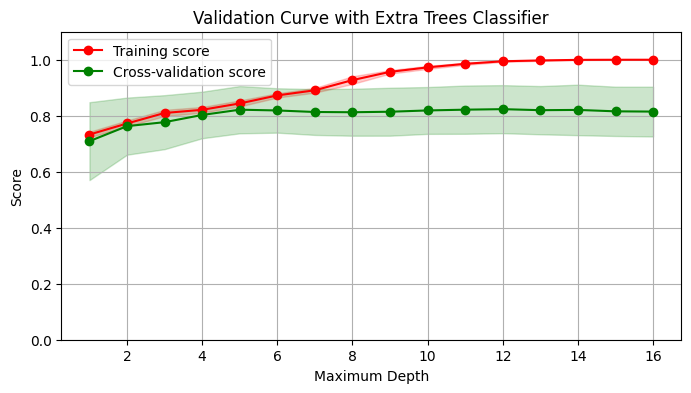

In [ ]:
# Plot the validation curve for max_depth parameter
base_model = ExtraTreesClassifier(n_estimators=84,
                                   criterion='entropy',
                                   max_features='sqrt',
                                   n_jobs=-1,
                                   random_state=42)
param_range = np.arange(1, 15, 1)

train_scores, test_scores = validation_curve(
    base_model, X, y, param_name="max_depth", param_range=param_range,
    cv=9, scoring="accuracy", n_jobs=-1
)

# Calculate mean and standard deviation for training and test scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot the validation curve
plt.figure(figsize=(8, 4))
plt.title("Validation Curve with Extra Trees Classifier")
plt.xlabel("Maximum Depth")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
plt.plot(param_range, train_mean, 'o-', label="Training score", color="r")
plt.plot(param_range, test_mean, 'o-', label="Cross-validation score", color="g")
plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, alpha=0.2, color="r")
plt.fill_between(param_range, test_mean - test_std, test_mean + test_std, alpha=0.2, color="g")
plt.legend(loc="best")
plt.grid()
plt.show()

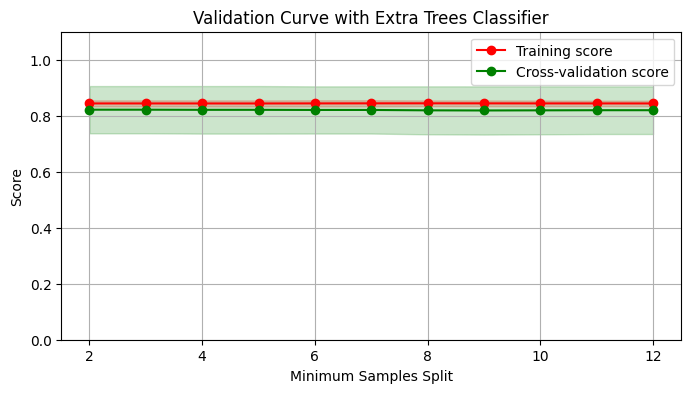

In [1613]:
# Plot the validation curve for max_depth parameter
base_model = ExtraTreesClassifier(n_estimators=84,
                                   criterion='entropy',
                                   max_depth=5,
                                   max_features='sqrt',
                                   n_jobs=-1,
                                   random_state=42)
param_range = np.arange(1, 13, 1)

train_scores, test_scores = validation_curve(
    base_model, X, y, param_name="min_samples_split", param_range=param_range,
    cv=9, scoring="accuracy", n_jobs=-1
)

# Calculate mean and standard deviation for training and test scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot the validation curve
plt.figure(figsize=(8, 4))
plt.title("Validation Curve with Extra Trees Classifier")
plt.xlabel("Minimum Samples Split")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
plt.plot(param_range, train_mean, 'o-', label="Training score", color="r")
plt.plot(param_range, test_mean, 'o-', label="Cross-validation score", color="g")
plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, alpha=0.2, color="r")
plt.fill_between(param_range, test_mean - test_std, test_mean + test_std, alpha=0.2, color="g")
plt.legend(loc="best")
plt.grid()
plt.show()

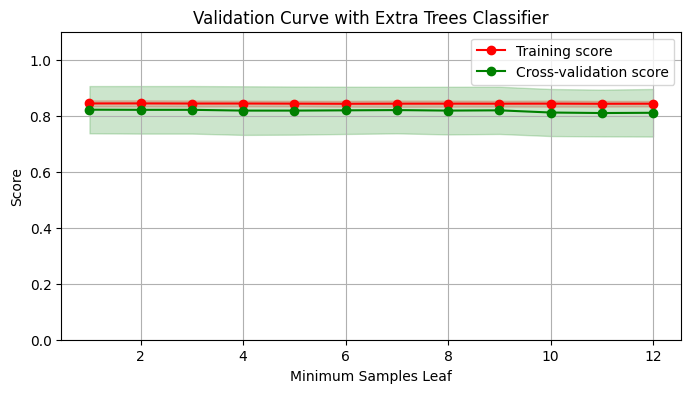

In [1615]:
# Plot the validation curve for max_depth parameter
base_model = ExtraTreesClassifier(n_estimators=84,
                                   criterion='entropy',
                                   max_depth=5,
                                   max_features='sqrt',
                                   n_jobs=-1,
                                   random_state=42)
param_range = np.arange(1, 13, 1)

train_scores, test_scores = validation_curve(
    base_model, X, y, param_name="min_samples_leaf", param_range=param_range,
    cv=9, scoring="accuracy", n_jobs=-1
)

# Calculate mean and standard deviation for training and test scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot the validation curve
plt.figure(figsize=(8, 4))
plt.title("Validation Curve with Extra Trees Classifier")
plt.xlabel("Minimum Samples Leaf")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
plt.plot(param_range, train_mean, 'o-', label="Training score", color="r")
plt.plot(param_range, test_mean, 'o-', label="Cross-validation score", color="g")
plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, alpha=0.2, color="r")
plt.fill_between(param_range, test_mean - test_std, test_mean + test_std, alpha=0.2, color="g")
plt.legend(loc="best")
plt.grid()
plt.show()

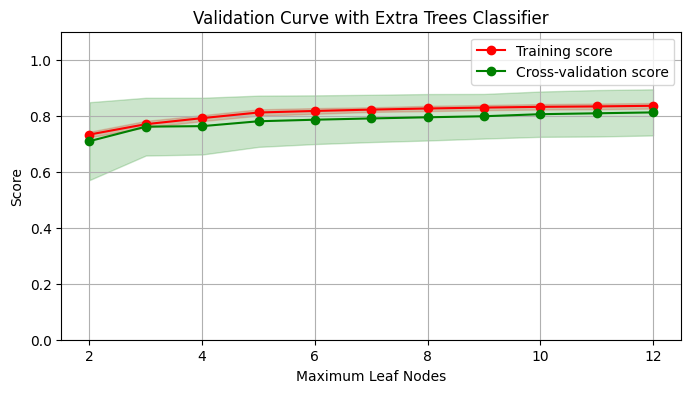

In [1619]:
# Plot the validation curve for max_depth parameter
base_model = ExtraTreesClassifier(n_estimators=84,
                                   criterion='entropy',
                                   max_depth=5,
                                   max_features='sqrt',
                                   n_jobs=-1,
                                   random_state=42)
param_range = np.arange(1, 13, 1)

train_scores, test_scores = validation_curve(
    base_model, X, y, param_name="max_leaf_nodes", param_range=param_range,
    cv=9, scoring="accuracy", n_jobs=-1
)

# Calculate mean and standard deviation for training and test scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot the validation curve
plt.figure(figsize=(8, 4))
plt.title("Validation Curve with Extra Trees Classifier")
plt.xlabel("Maximum Leaf Nodes")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
plt.plot(param_range, train_mean, 'o-', label="Training score", color="r")
plt.plot(param_range, test_mean, 'o-', label="Cross-validation score", color="g")
plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, alpha=0.2, color="r")
plt.fill_between(param_range, test_mean - test_std, test_mean + test_std, alpha=0.2, color="g")
plt.legend(loc="best")
plt.grid()
plt.show()

In [15]:
extra_model = ExtraTreesClassifier(n_estimators=84,
                                   criterion='entropy',
                                   max_depth=5,
                                   max_features='sqrt',
                                   n_jobs=-1,
                                   random_state=42)
extra_model.fit(X_train, y_train)

ExtraTreesClassifier(criterion='entropy', max_depth=5, n_estimators=84,
                     n_jobs=-1, random_state=42)

## **7. Model Evaluation**

In [16]:
results = []
y_train_pred = extra_model.predict(X_train)
y_test_pred = extra_model.predict(X_test)

train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)
cv_scores = cross_val_score(extra_model, X, y, cv=9)

results.append({
    "Model": 'Extra Trees Classifier',
    "Training Accuracy": train_acc,
    "Testing Accuracy": test_acc,
    "Cross-Val Mean": cv_scores.mean()
})

results_df = pd.DataFrame(results)
results_df

,Model,Training Accuracy,Testing Accuracy,Cross-Val Mean
0,Extra Trees Classifier,0.83945,0.85474,0.821534


In [1393]:
y_pred = extra_model.predict(X_test)
class_report = classification_report(y_test, y_test_pred, output_dict=True)
class_report_df = pd.DataFrame(class_report).transpose()
class_report_df

,precision,recall,f1-score,support
0,0.805263,0.93578,0.865629,327.00000
1,0.923358,0.77370,0.841930,327.00000
accuracy,0.854740,0.85474,0.854740,0.85474
macro avg,0.864310,0.85474,0.853780,654.00000
weighted avg,0.864310,0.85474,0.853780,654.00000


In [1395]:
feature_importance = extra_model.feature_importances_
features = X.columns

feat_imp_df = pd.DataFrame({'Feature': features, 'Importance': feature_importance})
feat_imp_df.sort_values(by='Importance', ascending=True, inplace=True)

# zero_importance_features = feat_imp_df[feat_imp_df['Importance'] < 0.0002]['Feature']
# print(zero_importance_features.to_list())
feat_imp_df

,Feature,Importance
58,PH_Per13,0.001600
74,PH_Var6,0.002717
22,AM_Std23,0.002770
11,AM_Std12,0.002790
49,PH_Per4,0.003183
...,...,...
33,PH_Std11,0.026465
25,PH_Std3,0.026640
36,PH_Std14,0.029429
41,PH_Std19,0.031392


In [1588]:
# Compute the overall feature importance of the specific set of features
feature_importance = extra_model.feature_importances_
features = X.columns

feat_imp_df = pd.DataFrame({'Feature': features, 'Importance': feature_importance})

# Filter and sum the importance of the specified columns
am_std_importance = feat_imp_df[feat_imp_df['Feature'].str.startswith('AM_Std')]['Importance'].sum()
ph_std_importance = feat_imp_df[feat_imp_df['Feature'].str.startswith('PH_Std')]['Importance'].sum()
ph_per_importance = feat_imp_df[feat_imp_df['Feature'].str.startswith('PH_Per')]['Importance'].sum()
ph_var_importance = feat_imp_df[feat_imp_df['Feature'].str.startswith('PH_Var')]['Importance'].sum()

total_importance = {
    'AM_Std': am_std_importance,
    'PH_Std': ph_std_importance,
    'PH_Per': ph_per_importance,
    'PH_Var': ph_var_importance
}

importance_df = pd.DataFrame(list(total_importance.items()), columns=['Feature Set', 'Importance'])
importance_df.sort_values(by='Importance', ascending=False, inplace=True)
importance_df

,Feature Set,Importance
1,PH_Std,0.443011
3,PH_Var,0.282451
0,AM_Std,0.145469
2,PH_Per,0.129068


## **8. Model Visualization**

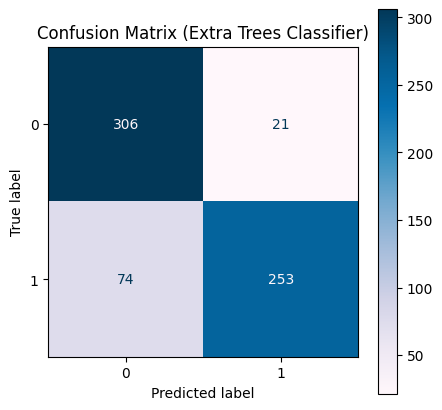

In [1576]:
# Plot confusion matrix
figsize=(5, 5)
fig, ax = plt.subplots(1, 1, figsize=figsize)
y_pred = extra_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=extra_model.classes_)
disp.plot(ax=ax, cmap=plt.cm.PuBu, values_format='d')
ax.title.set_text('Confusion Matrix (Extra Trees Classifier)')
plt.show()

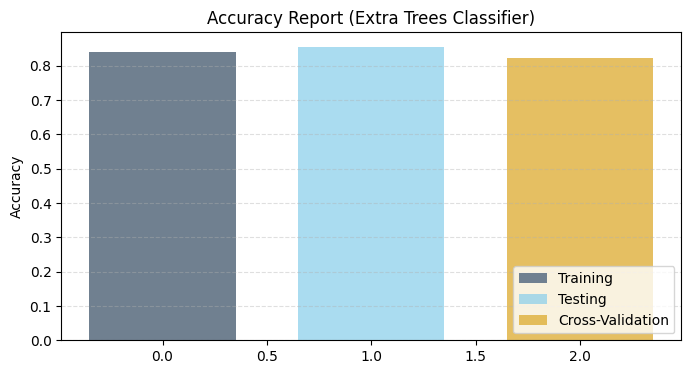

In [1574]:
# Plot Extra Trees Training, Testing and Cross-validation Accuracy
plt.figure(figsize=(8, 4))
bar_width = 0.7
index = np.arange(len(results_df))

plt.bar(index, results_df["Training Accuracy"], bar_width, color='slategrey', label='Training')
plt.bar(index + bar_width + 0.3, results_df["Testing Accuracy"], bar_width, color='skyblue', alpha=0.7, label='Testing')
plt.bar(index + 2 * (bar_width + 0.3), results_df["Cross-Val Mean"], bar_width, color='goldenrod', alpha=0.7, label='Cross-Validation')

plt.ylabel('Accuracy')
plt.title('Accuracy Report (Extra Trees Classifier)')
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.legend(loc='lower right')
plt.show()

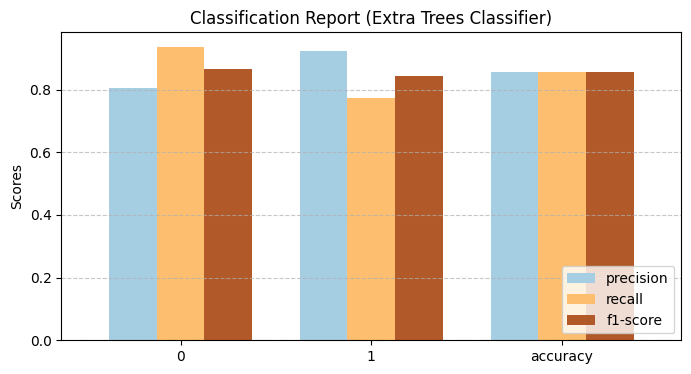

In [1578]:
y_pred = extra_model.predict(X_test)
class_report = classification_report(y_test, y_test_pred, output_dict=True)
class_report_df = pd.DataFrame(class_report).transpose()

# Filter to include only precision, recall, and f1-score
metrics_to_plot = ['precision', 'recall', 'f1-score']
class_report_df_filtered = class_report_df[metrics_to_plot]
bar_width = 0.75

class_report_df_filtered[:-2].plot(kind='bar', figsize=(8, 4), colormap='Paired', width=bar_width)
plt.title('Classification Report (Extra Trees Classifier)')
plt.ylabel('Scores')
plt.xticks(rotation=0)
plt.legend(loc='lower right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

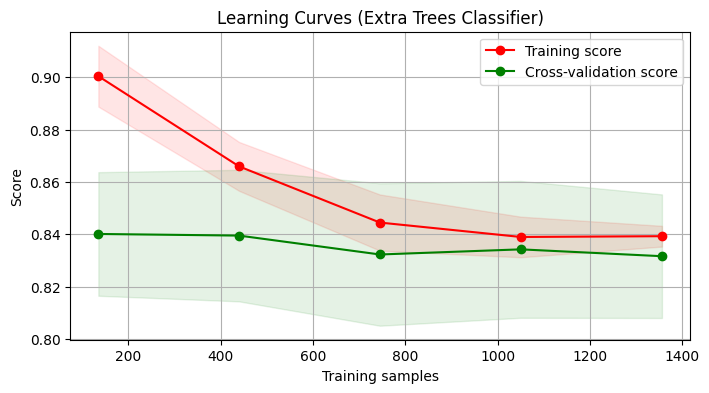

In [1596]:
# Generate learning curves
train_sizes, train_scores, test_scores = learning_curve(extra_model, X_train, y_train, cv=9, scoring='accuracy', n_jobs=-1)

# Calculate mean and standard deviation
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plot learning curves
plt.figure(figsize=(8, 4))
plt.title("Learning Curves (Extra Trees Classifier)")
plt.xlabel("Training samples")
plt.ylabel("Score")
plt.grid()

plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

plt.legend(loc="best")
plt.show()

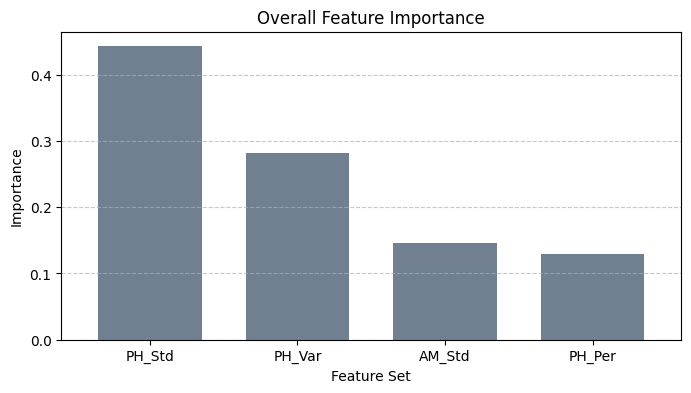

In [1594]:
importance_df.plot(kind='bar', x='Feature Set', y='Importance', legend=False, color='slategrey', figsize=(8, 4), width=0.7)
plt.title('Overall Feature Importance')
plt.ylabel('Importance')
plt.xlabel('Feature Set')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

## **9. Save Model**

In [ ]:
# # Save the best model
# insense = ExtraTreesClassifier(n_estimators=84,
#                                    criterion='entropy',
#                                    max_depth=5,
#                                    max_features='sqrt',
#                                    n_jobs=-1,
#                                    random_state=42)
# insense.fit(X, y)
# joblib.dump(extra_model, '../model/insense_v1.6.pkl')